In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
# Path to datasets inside Google Drive
DATA_FOLDER = "/content/drive/MyDrive/indiv-datasets"

# Check contents
os.listdir(DATA_FOLDER)

['AAPL_Validation.csv',
 'AAPL_Test.csv',
 'FB_Train.csv',
 'AAPL_Train.csv',
 'MSFT_Validation.csv',
 'TSLA_Validation.csv',
 'FB_Validation.csv',
 'TSLA_Train.csv',
 'FB_Test.csv',
 'MSFT_Test.csv',
 'MSFT_Train.csv',
 'TSLA_Test.csv']

In [18]:
STOCKS = ["AAPL", "MSFT", "FB", "TSLA"]

train_dfs = []
for stock in STOCKS:
    train_path = os.path.join(DATA_FOLDER, f"{stock}_Train.csv")
    df_train = pd.read_csv(train_path)
    df_train["Stock"] = stock
    train_dfs.append(df_train)

train_df = pd.concat(train_dfs, ignore_index=True)

X_train = train_df.drop(columns=["Close", "Stock", "Date"])
y_train = train_df["Close"]

print(f"✅ Combined training set shape: {X_train.shape}")

✅ Combined training set shape: (13708, 5)


In [19]:
param_grid = {
    "max_depth": [5, 10, 15, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

grid_search = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

print(f"✅ Best parameters: {grid_search.best_params_}")

✅ Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


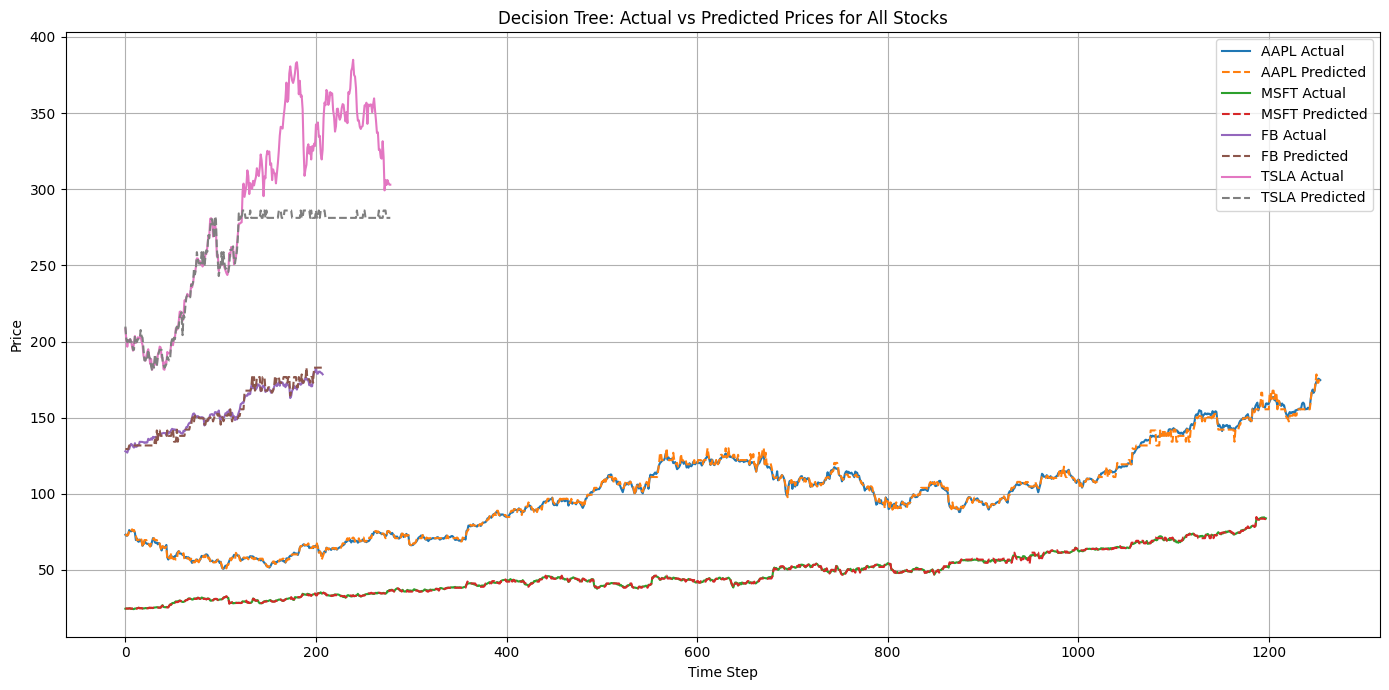

,MAE,MSE,RMSE,R²
AAPL,1.201365,2.959803,1.720408,0.996540
MSFT,0.432232,0.328444,0.573100,0.998290
FB,2.471024,9.925343,3.150451,0.957089
TSLA,31.798535,2022.341777,44.970454,0.473631


In [24]:
def evaluate_stock(model):
    import matplotlib.pyplot as plt
    results = {}

    plt.figure(figsize=(14, 7))  # One figure for all stocks

    for stock in STOCKS:
        test_path = os.path.join(DATA_FOLDER, f"{stock}_Test.csv")
        df_test = pd.read_csv(test_path)

        X_test = df_test.drop(columns=["Close", "Stock", "Date"], errors="ignore")
        y_test = df_test["Close"]

        y_pred = model.predict(X_test)

        # Compute metrics
        mae  = mean_absolute_error(y_test, y_pred)
        mse  = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2   = r2_score(y_test, y_pred)

        # Store metrics
        results[stock] = {"MAE": mae, "MSE": mse, "RMSE": rmse, "R²": r2}

        # Plot actual vs predicted for this stock
        plt.plot(y_test.values, label=f"{stock} Actual", linewidth=1.5)
        plt.plot(y_pred, linestyle="--", label=f"{stock} Predicted", linewidth=1.5)

    # Final combined plot
    plt.title("Decision Tree: Actual vs Predicted Prices for All Stocks")
    plt.xlabel("Time Step")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Return metrics as DataFrame
    return pd.DataFrame(results).T

# Call the function once
results_df = evaluate_stock(best_model)
results_df